# Aragon Conviction Voting Model - Version 3


New to this version 3  model are the following elements:

* Adding the realism that not all participant tokens are being allocated to proposals at each timestep.
* Refactored parameters and system initialization to make more readable and consistent.
* Changed file structure and file names to align with emerging cadCAD standards.
* Making the distinction between effective and total supply.
* Refining alpha calculations to more accurately reflect the 1Hive implementation. Discussion of alpha and its relation to alpha in the contract and how it relates to the timescales
* Updated differential specification and write-up to respect new state variables
* Moved all unit denominations to Honey, the 1Hive governance token.
* Added system health metrics


# An Introduction to Conviction Voting

Conviction Voting is a real time vote streaming tool, and a novel approach to continuously organizing a communities preferences into discrete decisions in the management of that communities resources. 

Suppose a group of people want to coordinate to make a collective decision. Social dynamics such as discussions, signaling, and even changing one's mind based on feedback from other's input play an important role in these processes. Conviction Voting can augment these social dynamics by making group preferences more transparent, and channels a plurality of preferences into discrete outcomes. In our case we are interested in a procedure which supports asynchronous interactions, and provides visibility into likely outcomes prior to their resolution to serve as a driver of debate and healthy forms of coalition building. Furthermore, participants should be able to show support for multiple initiatives, and to vary the level of support shown. Participants have a quantity of signaling power which may be fixed or variable, homogenous (e.g. democratic) or heterogenous (e.g. plutocratic or meritocratic). 

Strictly speaking conviction voting is less like voting and more like a signal processing tool. Framing the approach and the initial algorithm design was done by Michael Zargham and published in a short research proposal [Social Sensor Fusion](https://github.com/BlockScience/conviction/blob/master/social-sensorfusion.pdf). This work is based on a dynamic resource allocation algorithm presented in Dr. Zargham's PhD Thesis. 

The work proceeded in collaboration with the Commons Stack, including expanding on the python implementation to make up part of the Commons Simulator game. An implemention of Conviction Voting as a smart contract within the Aragon Framework was developed by 1Hive.org and is currently being used for community decision making for allocations of their community currency, Honey.

<br>

## Exploring the Conviction Voting algorithm

For a more in-depth look at the mathematical derivation of Conviction Voting, and to get a better understanding of its various parameters and how they are defined, be sure to read more in the [algorithm_overview.ipynb](https://nbviewer.jupyter.org/github/BlockScience/Aragon_Conviction_Voting/blob/master/algorithm_overview.ipynb).


<br>

## Deriving & Understanding Alpha

Understanding the derivations of the Conviction Voting parameters can give you insight into how changing them may impact your system. The $\alpha$ parameter regulates the half life decay rate of conviction. See the [Deriving_Alpha](https://nbviewer.jupyter.org/github/BlockScience/Aragon_Conviction_Voting/blob/master/models/v3/Deriving_Alpha.ipynb) notebook for a full derivation and more details about alpha.

![](https://i.imgur.com/JemMMlo.png)

<br>

## The Trigger Function: Converting Signals to Discrete Decisions

Conviction can be considered like a fluctuating kinetic energy, with the Trigger function acting as a required activation energy for proposals to pass. This is the mechanism by which a continuous community preference turns into a discrete action event: passing a proposal. See [Trigger Function Explanation](https://nbviewer.jupyter.org/github/BlockScience/Aragon_Conviction_Voting/blob/master/models/v3/Trigger_Function_Explanation.ipynb) for more details around the trigger function and how it works.

![](images/stockflow_cv_trigger.png)




## Notion of Honey supply

#### Total supply = $S$
#### Effective supply = $E$, honey committed towards votes (whether for proposals or abstain)
#### Funding Pool = $F$, community funding pool where proposals are funded from
#### Other supply = $L$, effectively slack. Funds could be in cold storage, in liquidity pools or otherwise in any address not actively participating in conviction voting.
$$S = F + E + L$$ 

System has the right to do direct mints:
$$F^+ = F + minted tokens$$
$$S^+ = S + minted tokens$$

The system may also see the arrival of new funds which come from outside supply and are donated to the funding pool:
$$L^+ = L - donated tokens$$
$$F^+ = F + donated tokens$$

When tokens are added to a liquidity pool or cold wallet and removed from staking on proposals:
$$L^+ = L + tokens$$ 
$$E^+ = E - tokens$$ 

When tokens are removed from a liquidity pool or cold wallet and staked towards proposals:
$$L^+ = L - tokens$$ 
$$E^+ = E + tokens$$

Tokens in $L$ or $E$ are defined at the level of the account holding them.
<br>



## cadCAD Model Structure

If you are looking to build upon this model or others like it, you may want to read more about the structure of this cadCAD model in the [model_structure.ipynb](https://nbviewer.jupyter.org/github/BlockScience/Aragon_Conviction_Voting/blob/master/model_structure.ipynb) file.



# Simulation

## Configuration
Let's factor out into its own notebook where we review the config object and its partial state update blocks. We will initialize the network x object and pull out the simulation configuration, state_variables, and partial state update blocks from the [config.py](model/config.py).

In [1]:
from model import config
from model.parts.sys_params import initial_values
from model.parts.utils import *

Params (config.py) :  {'beta': 0.2, 'rho': 0.0025, 'alpha': 0.7937005259840998, 'gamma': 0.001, 'sensitivity': 0.75, 'tmin': 1, 'min_supp': 1, 'base_completion_rate': 45, 'base_failure_rate': 180, 'base_engagement_rate': 0.3, 'lowest_affinity_to_support': 0.3}


We are loading the state_variables and configuration from the [state_variables](model/state_variables.py) and the [config](model/config.py) python files. If you would like to change these initial values, please modify prior to running this notebook or restart the kernal and run all to see your changes.

In [2]:
from copy import deepcopy
from cadCAD import configs

# pull out configurations to illustrate
sim_config,state_variables,partial_state_update_blocks = config.get_configs()
state_variables['network'] = config_initialization(configs,initial_values)


Params (config.py) :  {'beta': 0.2, 'rho': 0.0025, 'alpha': 0.7937005259840998, 'gamma': 0.001, 'sensitivity': 0.75, 'tmin': 1, 'min_supp': 1, 'base_completion_rate': 45, 'base_failure_rate': 180, 'base_engagement_rate': 0.3, 'lowest_affinity_to_support': 0.3}


In [3]:
partial_state_update_blocks

[{'policies': {'random': <function model.parts.system.driving_process(params, step, sL, s)>},
  'variables': {'network': <function model.parts.system.update_network(params, step, sL, s, _input)>,
   'effective_supply': <function model.parts.system.increment_supply(params, step, sL, s, _input)>}},
 {'policies': {'random': <function model.parts.system.minting_rule(params, step, sL, s)>},
  'variables': {'total_supply': <function model.parts.system.mint_to_supply(params, step, sL, s, _input)>,
   'funds': <function model.parts.system.mint_to_funds(params, step, sL, s, _input)>}},
 {'policies': {'completion': <function model.parts.participants.check_progress(params, step, sL, s)>},
  'variables': {'sentiment': <function model.parts.participants.update_sentiment_on_completion(params, step, sL, s, _input)>,
   'network': <function model.parts.participants.complete_proposal(params, step, sL, s, _input)>}},
 {'policies': {'release': <function model.parts.proposals.trigger_function(params, step

### Parameters

Initial values are the starting values for the simulation.

In [4]:
initial_values

{'sentiment': 0.6, 'n': 30, 'm': 7, 'funds': 4867.21, 'supply': 22392.22}

$n$ is initial participants, whereas $m$ is initial proposals.

Sim_config holds the global hyperparameters for the simulations

In [5]:
sim_config[0]['M']

{'beta': 0.2,
 'rho': 0.0025,
 'alpha': 0.7937005259840998,
 'gamma': 0.001,
 'sensitivity': 0.75,
 'tmin': 1,
 'min_supp': 1,
 'base_completion_rate': 45,
 'base_failure_rate': 180,
 'base_engagement_rate': 0.3,
 'lowest_affinity_to_support': 0.3}

Initial state variable values

In [6]:
state_variables

{'network': <networkx.classes.digraph.DiGraph at 0x7f5bcff85940>,
 'funds': 4867.21,
 'sentiment': 0.6,
 'effective_supply': 14020.008000000002,
 'total_supply': 22392.22,
 'fractionOfSupplyForVoting': 0,
 'fractionOfSupplyInPool': 0,
 'fractionOfProposalStages': 0,
 'fractionOfFundStages': 0}

## Hyperparameter explanations:
* $\beta$: .2,  upper bound on share of funds dispersed in the example Trigger Function
* $\rho$: 0.0025,  scale parameter for the example Trigger Function
* $\alpha$: 0.79370, timescale set in days with 3 day half-life
* $\gamma$: 0.001, the expansion of supply per per day
* sensitivity: 0.75, sensitivity of participant decisions to changes in affinity 
* tmin: 1, unit days, minimum periods passed before a proposal can pass
* min_supp: 1, number of tokens that must be staked for a proposal to be a candidate
* base_completion_rate: 45, expected number of days to complete a proposal
* base_failure_rate: 180, expected number of days until a proposal will fail
* base_engagement_rate: 0.3, probability of being active on a certain day 
* lowest_affinity_to_support: 0.3, lowest affinity required to support a proposal


#### Exploring the State Data Structure

A graph is a type of temporal data structure that evolves over time. A graph $\mathcal{G}(\mathcal{V},\mathcal{E})$ consists of vertices or nodes, $\mathcal{V} = \{1...\mathcal{V}\}$ and is connected by edges  $\mathcal{E} \subseteq \mathcal{V} \times \mathcal{V}$.

See *Schema of the states* above for more details


Let's explore!

In [7]:
# To explore our model prior to the simulation, we extract key components from our networkX object into lists.
proposals = get_nodes_by_type(state_variables['network'], 'proposal')
participants = get_nodes_by_type(state_variables['network'], 'participant')
supporters = get_edges_by_type(state_variables['network'], 'support')
influencers = get_edges_by_type(state_variables['network'], 'influence')
competitors = get_edges_by_type(state_variables['network'], 'conflict')

In [8]:
#sample a participant
state_variables['network'].nodes[participants[0]]

{'type': 'participant',
 'holdings': 784.0042194359262,
 'sentiment': 0.05381974967826486}

Text(0, 0.5, 'Count of Participants')

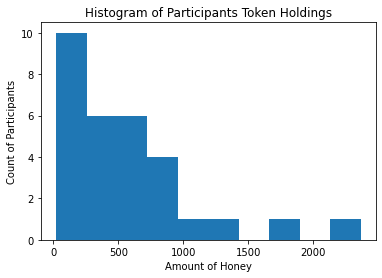

In [9]:
# Let's look at the distribution of participant holdings at the start of the sim
plt.hist([ state_variables['network'].nodes[i]['holdings'] for i in participants])
plt.title('Histogram of Participants Token Holdings')
plt.xlabel('Amount of Honey')
plt.ylabel('Count of Participants')


Text(0.5, 1.0, 'Participants Social Network')

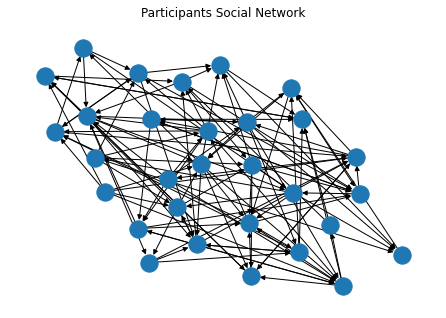

In [10]:
nx.draw_spring(state_variables['network'], nodelist = participants, edgelist=influencers)
plt.title('Participants Social Network')

In [11]:
#lets look at proposals
state_variables['network'].nodes[proposals[0]]

{'type': 'proposal',
 'conviction': 0,
 'status': 'candidate',
 'age': 0,
 'funds_requested': 235.28938617345855,
 'trigger': 8462.465783674517}

Proposals initially start without any conviction, and with the status of a candidate. If the proposal's amount of conviction is greater than its trigger, then the proposal moves to active and its funds requested are granted. 

All initial proposals start with 0 conviction and state 'candidate' so we can simply examine the amounts of funds requested

In [12]:
funds_array = np.array([state_variables['network'].nodes[i]['funds_requested'] for i in proposals])
conviction_required = np.array([trigger_threshold(r, initial_values['funds'], initial_values['supply'], sim_config[0]['M']['alpha'],sim_config[0]['M']) for r in funds_array])

Text(0, 0.5, 'Amount of Honey requested(as a Fraction of Funds available)')

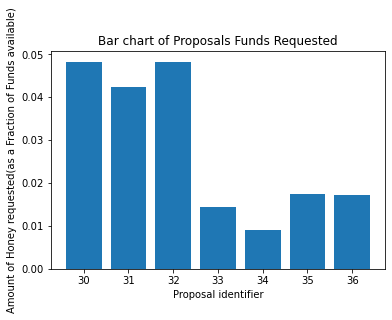

In [13]:
plt.bar( proposals, funds_array/initial_values['funds'])
plt.title('Bar chart of Proposals Funds Requested')
plt.xlabel('Proposal identifier')
plt.ylabel('Amount of Honey requested(as a Fraction of Funds available)')

Small proposals will all be similar and big proposals will go up a lot. See the [Alpha explainer](Deriving_Alpha.ipynb) file for more explanation. As you can see below, the largest proposal is 0.175 of the max conviction allowed, which will let them pass relatively quickly.

Text(0, 0.5, 'Percentage of Max Conviction')

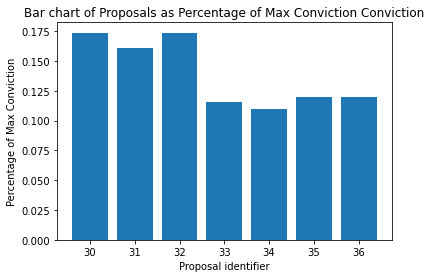

In [14]:
plt.bar(proposals, conviction_required / (state_variables['effective_supply']/(1-sim_config[0]['M']['alpha'])))
plt.title('Bar chart of Proposals as Percentage of Max Conviction Conviction')
plt.xlabel('Proposal identifier')
plt.ylabel('Percentage of Max Conviction')

Text(0, 0.5, 'Amount of Conviction')

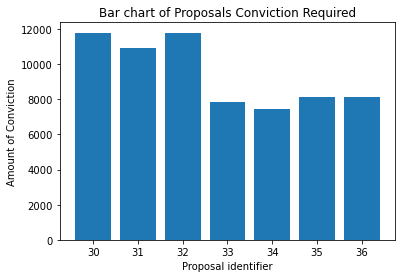

In [15]:
plt.bar(proposals, conviction_required)
plt.title('Bar chart of Proposals Conviction Required')
plt.xlabel('Proposal identifier')
plt.ylabel('Amount of Conviction')

Conviction is a concept that arises in the edges between participants and proposals. In the initial conditions there are no votes yet so we can look at that later however, the voting choices are driven by underlying affinities which we can see now.

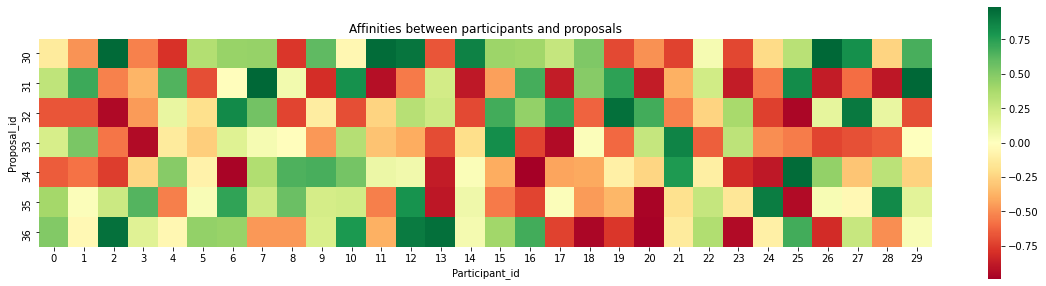

In [16]:
affinities_plot(state_variables['network'], dims = (20, 5))

## Run simulation

Now we will create the final system configuration, append the genesis states we created, and run our simulation.

In [17]:
import numpy as np
import pandas as pd
from model import run
pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline

rdf = run.run()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100, 11, 1, 9)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 63.87s


## Perform a state variable schema check

In [18]:
from model.state_schema import state_schema

In [19]:
schema_check(rdf,state_schema)

{'network': True,
 'funds': True,
 'sentiment': True,
 'effective_supply': True,
 'total_supply': True,
 'fractionOfSupplyForVoting': True,
 'fractionOfSupplyInPool': True,
 'fractionOfProposalStages': True,
 'fractionOfFundStages': True}

The check returns the same datatypes as expected, which passes one of our controls that the simulation performed as anticipated

After the simulation has run successfully, and we have checked the schema, we perform some postprocessing to extract node and edge values from the network object and add as columns to the pandas dataframe. For the rdf, we take only the values at the last substep of each timestep in the simulation.

In [20]:
df= run.postprocessing(rdf,0)

In [21]:
df.head(5)

,network,funds,sentiment,effective_supply,total_supply,fractionOfSupplyForVoting,fractionOfSupplyInPool,fractionOfProposalStages,fractionOfFundStages,simulation,...,age_all,conviction_all,triggers_all,conviction_share_of_trigger_all,percentageOfActiveProposals,percentageOfCompletedProposals,percentageOfKilledProposals,percentageOfActiveFundsRequested,percentageOfCompletedFundsRequested,percentageOfKilledFundsRequested
6,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4889.60,0.60,14066.72,22414.61,0.63,4.58,"{'percentageOfActive': 0.0, 'percentageOfCompl...","{'percentageOfActiveFundsRequested': 0.0, 'per...",0,...,"[1, 1, 1, 1, 1, 1, 1, 1, 1]","[882.2497483453889, 0.0, 31.6011916036318, 0.0...","[7386.828138248423, 6843.861913317379, 7375.75...","[0.11943553198119883, 0.0, 0.00428447137170122...",0.00,0.00,0.33,0.00,0.00,0.33
12,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4912.02,0.60,14066.72,22437.03,0.63,4.57,"{'percentageOfActive': 0.0, 'percentageOfCompl...","{'percentageOfActiveFundsRequested': 0.0, 'per...",0,...,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1]","[1742.0050267688518, 0.0, 216.7442553106338, 0...","[7389.846709465001, nan, 7378.831240818275, na...","[0.23572952122777752, nan, 0.02937379216801250...",0.00,0.00,0.45,0.00,0.00,0.45
18,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4934.45,0.60,14066.72,22459.46,0.63,4.55,"{'percentageOfActive': 0.0, 'percentageOfCompl...","{'percentageOfActiveFundsRequested': 0.0, 'per...",0,...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 1]","[2424.3932434711605, 0.0, 363.692402357189, 0....","[7368.524854094631, nan, 7357.607000641544, na...","[0.3290201623088703, nan, 0.049430800303070954...",0.00,0.00,0.46,0.00,0.00,0.44
24,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4956.91,0.60,14086.70,22481.92,0.63,4.54,"{'percentageOfActive': 0.0, 'percentageOfCompl...","{'percentageOfActiveFundsRequested': 0.0, 'per...",0,...,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 2, 2, 1]","[2966.0051299931347, 0.0, 1381.8975762087014, ...","[7347.46670706167, nan, 7336.644981701139, nan...","[0.40367724662739873, nan, 0.1883555194036774,...",0.00,0.00,0.50,0.00,0.00,0.45
30,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4895.20,0.70,14132.34,22504.41,0.63,4.60,"{'percentageOfActive': 0.06666666666666667, 'p...",{'percentageOfActiveFundsRequested': 0.0468010...,0,...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 3, 3, 2, 1]","[3607.5795825708615, 0.0, 2259.4512147279015, ...","[7337.075132860246, nan, 7326.332842349811, na...","[0.4916917868829976, nan, 0.3084013876174395, ...",0.07,0.00,0.47,0.05,0.00,0.34


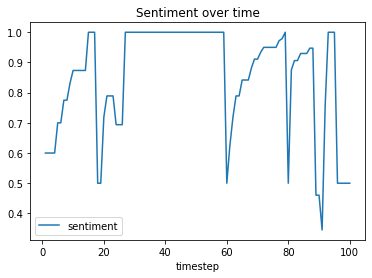

In [22]:
df.plot('timestep','sentiment',title='Sentiment over time')

The above plot demonstrates system sentiment changing over time as proposals pass or fail.

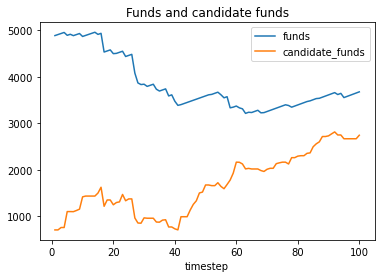

In [23]:
df.plot('timestep',['funds', 'candidate_funds'],title ='Funds and candidate funds')

In the above graph, funds represent the total available funds, whereas candidate funds represent total funds requested by candidate proposals.

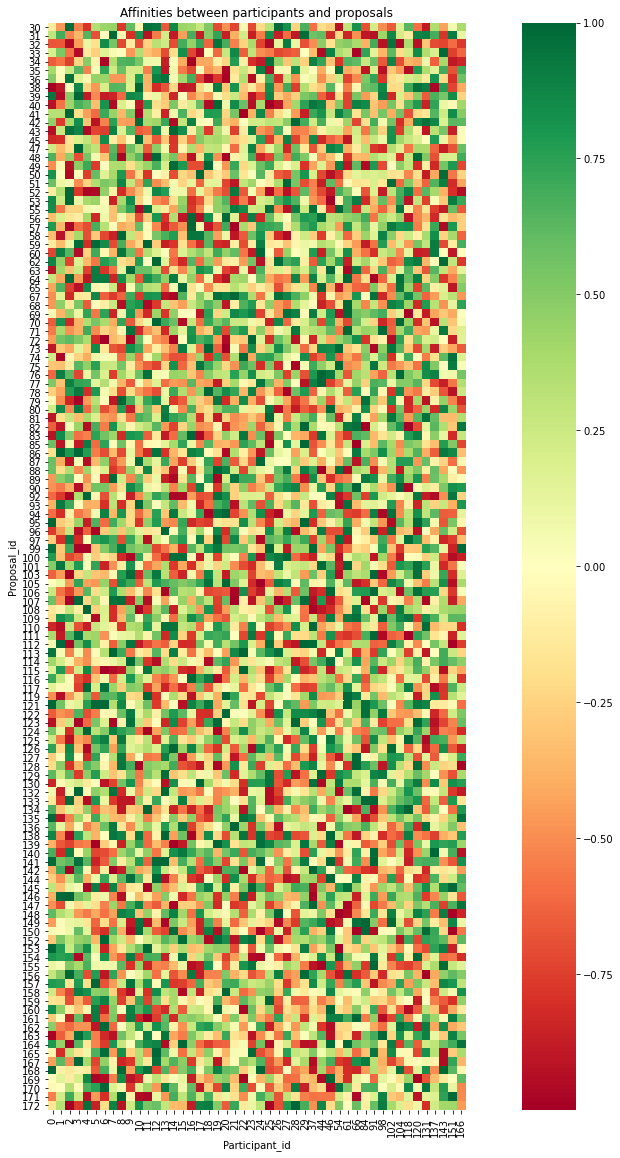

In [24]:
affinities_plot(df.network.values[-1],dims = (20,20))

The above matrix represents participant affinities towards proposals, ranging from -1 to +1.

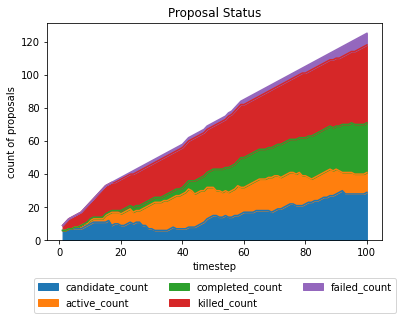

In [25]:
df.plot(x='timestep',y=['candidate_count','active_count','completed_count', 'killed_count', 'failed_count'],
         kind='area')
plt.title('Proposal Status')
plt.ylabel('count of proposals')
plt.legend(ncol = 3,loc='upper center', bbox_to_anchor=(0.5, -0.15))

The above graph shows the number of various types of proposals at a range of timesteps. Ecosystems with more completed proposals will have higher overall agent sentiment than systems with more failed and killed proposals.

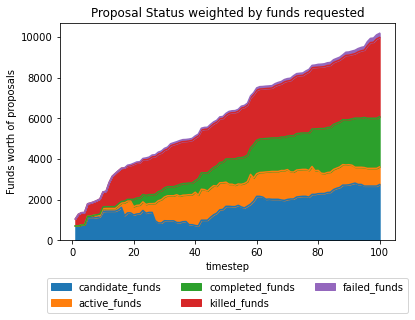

In [26]:
df.plot(x='timestep',y=['candidate_funds','active_funds','completed_funds', 'killed_funds', 'failed_funds'], kind='area')
plt.title('Proposal Status weighted by funds requested')
plt.ylabel('Funds worth of proposals')
plt.legend(ncol = 3,loc='upper center', bbox_to_anchor=(0.5, -0.15))

The above graph shows the amount of funds requested by various types of proposals at a range of timesteps.

In [27]:
nets = df.network.values

/home/aclarkdata/repos/Aragon_Conviction_Voting/models/v3/model/parts/utils.py:699: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


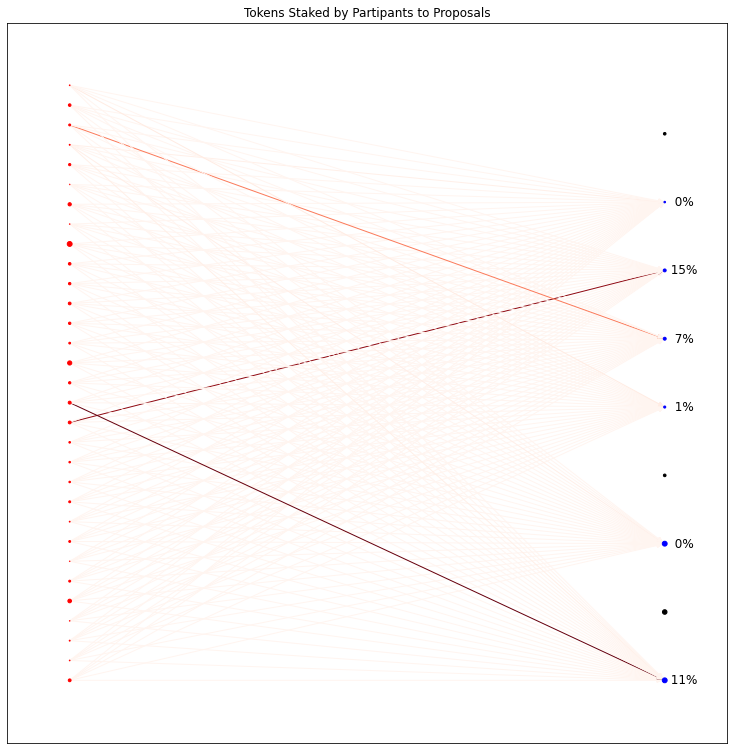

In [28]:
K = 0
N = 1

snap_plot(nets[K:N], size_scale = 1/10,dims = (10,10),savefigs=True)

On the left side are participants, with the right side of the graph being the proposals. With this graph, we can see the links between the participants and the proposals that they support. The percentage on the right hand are the the amount of the required amount to pass that has been fulfilled.

You can move the K and N to different points within the 100 timesteps, 0 indexed, to see how the model evolves over time. 

As you can see with the plot above at the start of the simulation, no proposals have been formally supported yet. Below we can see many interactions between agents and proposals.

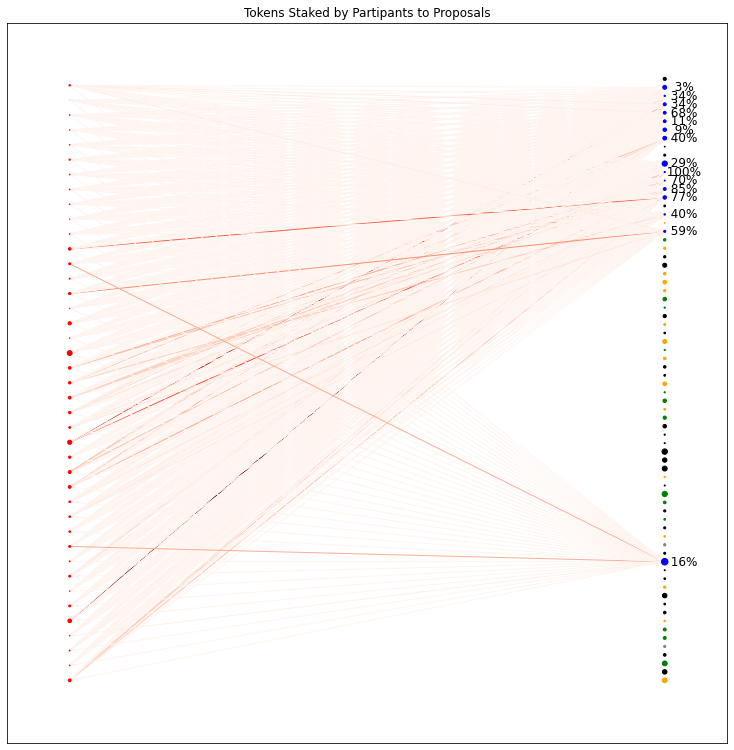

In [29]:
snap_plot(nets[50:51], size_scale = 1/10,dims = (10,10),savefigs=True)

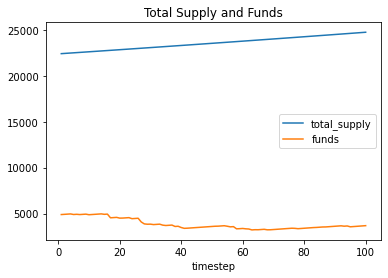

In [30]:
df.plot('timestep',['total_supply','funds'],title='Total Supply and Funds')

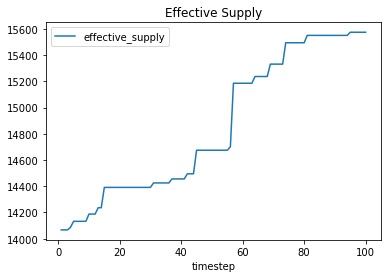

In [31]:
df.plot('timestep',['effective_supply'],title='Effective Supply')

As expected *effective_supply* is increasing with the arrival of new participants.

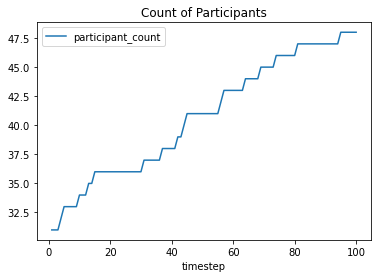

In [32]:
df.plot('timestep',['participant_count'],title='Count of Participants')

## Review system health metrics

Below we will analyze system health metrics such as fraction of supply used for voting (which is effective supply over total supply), and percentage of proposals and requested funds in different stages. 

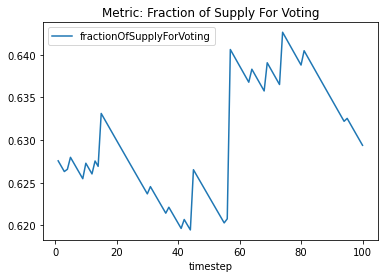

In [33]:
df.plot('timestep',['fractionOfSupplyForVoting'],title='Metric: Fraction of Supply For Voting')

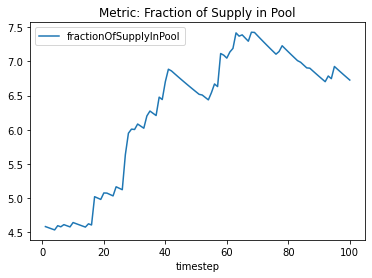

In [34]:
df.plot('timestep',['fractionOfSupplyInPool'],title='Metric: Fraction of Supply in Pool')

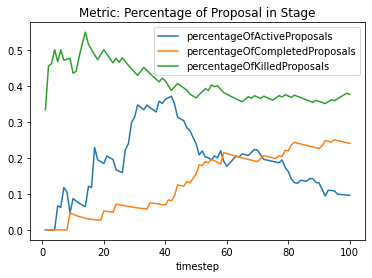

In [35]:
df.plot('timestep',['percentageOfActiveProposals','percentageOfCompletedProposals',
                    'percentageOfKilledProposals'],
        title='Metric: Percentage of Proposal in Stage')

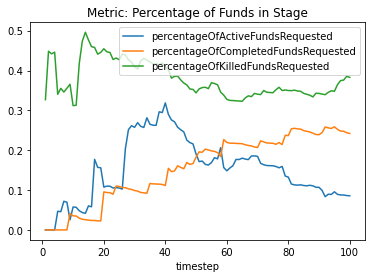

In [36]:
df.plot('timestep',['percentageOfActiveFundsRequested','percentageOfCompletedFundsRequested',
                    'percentageOfKilledFundsRequested'],
       title='Metric: Percentage of Funds in Stage')

## Conclusion

We have created a conviction voting model that closely adheres to the 1Hive implementation. This notebook describes the use case, how the model works, and provides descriptions of how it fits together. We have utilized all four levels of a cadCAD simulation: Behaviors, Mechanisms, States, and Metrics. To continue to expand the model, we can take our designed flight simulator and begin to stress test and make it antifragile through parameter sweeps, A/B testing, and monte carlo runs. Additionally, we could add the following enhancements:

* **Add a uniswap instance**
    * A next step to model the 1Hive ecosystem would be to model the Uniswap interface. With this interface, agents would be able to add or remove liquidity, buy or redeem Honey for more voting power, and ultimately enter or leave the system. Visit the [following](https://github.com/BlockScience/uniswap/blob/master/simplified-uniswap.ipynb) to see simplified uniswap implementation.
* **Develop parameter sweeps or A/B tests**
* **Mixing of token holdings among participants**
    * Introducing heterogeneous token holdings to create a model more representative of the live system
* **Proposals which are good or no good together**
    * Introducing conflicts and synergies between proposals 
* **Affects of outcomes on sentiment**
    * Introducing agent sentiment increasing with proposals completed and decreasing with proposals killed


## Additional Considerations when Deploying CV
* **Timescales**: whether your system is operating in block times, or more human understandable timescales like hours, days, or weeks, these considerations need to be factored into your model
* **Minimum candidacy times** proposals should be active for a minimum period to ensure appropriate dialog occurs within the community, regardless of level of support
* **Minimum conviction required** for small proposals
to prevent small proposal spamming from draining the communal funding pool, all proposals should have some minimum conviction required to pass
* **Effective supply**
to avoid slow conviction aggregation due to "inactive" tokens (e.g. locked up in cold storage or liquidity pool, without active participation in governance), effective supply is the portion of tokens that are active in community governance
* **Proposal Approval & Feedback Process**
the proposal process could make use of additional mechanisms like fund escrow, proposal backlog processes, reviews/validation & disputability/contestation to ensure that the incentive to game the system is kept to a minimum through responsible community oversight